In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import os, random
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing import image
from sklearn.metrics import accuracy_score, classification_report
from pathlib import Path
from PIL import Image 
from keras.callbacks import EarlyStopping,ModelCheckpoint
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
from sklearn.metrics import confusion_matrix
from matplotlib import cm

In [2]:
import glob
full = []
label1=[]
for img in glob.glob("./data/Full  Water level*.jpeg")+ glob.glob("./data/Full  Water level/*.png"):
    
    n= cv2.imread(img) 
    n = Image.fromarray(n,'RGB')
    n_res=n.resize((80,80))
    full.append(n_res)
    label1.append(0)
    
half = []
label2=[]
for img in glob.glob("./data/Half water level/*.jpeg")+glob.glob("./data/Half water level/*.png"):
    m= cv2.imread(img) 
    m = Image.fromarray(m,'RGB')
    m_res=m.resize((80,80))
    m1=m_res.rotate(15)
    half.append(m_res)
    half.append(m1)
    label2.append(1)
    label2.append(1)
  
over = []
label3=[]
for img in glob.glob("./data/Overflowing/*.jpeg")+glob.glob("./data/Overflowing/*.png"):
    m= cv2.imread(img) 
    m = Image.fromarray(m,'RGB')
    m_res=m.resize((80,80))
    m1=m_res.rotate(15)
    m2=m_res.rotate(-15)
    over.append(m_res)
    over.append(m1)
    over.append(m2)
    label3.append(2)
    label3.append(2)
    label3.append(2)    

In [3]:
len(full), len(half) ,len(over)

(53, 278, 117)

In [4]:
img=full+half+over
label=label1+label2+label3

In [5]:
img = np.array(img, dtype=object)
label = np.array(label, dtype=object)


C:\Users\ASUS\AppData\Local\Temp\ipykernel_5068\2841007735.py:1: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  img = np.array(img, dtype=object)


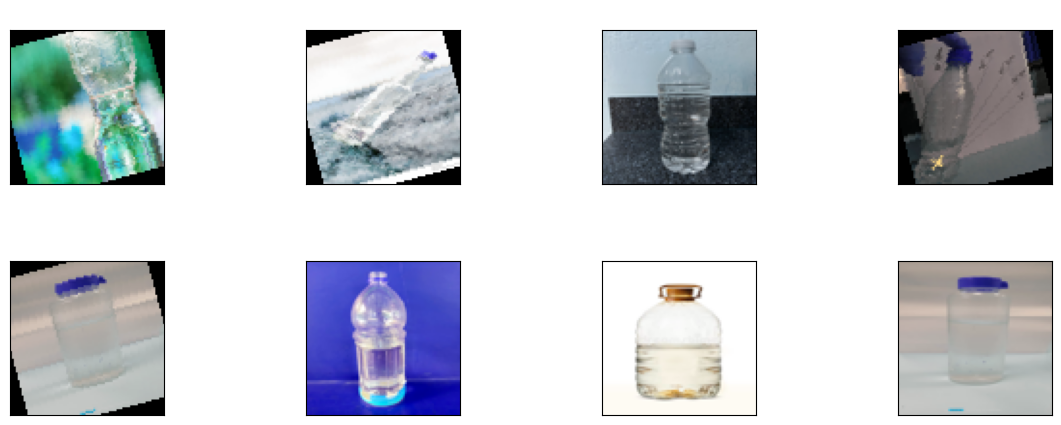

In [6]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(14, 5))
x, y = 4, 2

# Assuming img is a valid 3D array (height, width, channels)
for i in range(8):
    r = np.random.randint(0, img.shape[0], 1)
    plt.subplot(y, x, i + 1)
    plt.imshow(img[r[0]], cmap='gray')  # Adjust this line based on image dimensions
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    plt.title(label[r[0]], color="w")
    plt.xticks([]), plt.yticks([])

plt.show()

* 0 : FULL
* 1 : HALF
* 2 : OVERFLOWING

In [7]:
imgs=[]
from tensorflow.keras.utils import img_to_array
for i in img:
  x = img_to_array(i)
  imgs.append(x)
imgs = np.array(imgs)/255
imgs.shape

(448, 80, 80, 3)

In [8]:
datagen = ImageDataGenerator(height_shift_range=0.3,fill_mode='nearest')
datagen.fit(imgs)
generated_imgs = []
generated_labels = []
for x_batch, y_batch in datagen.flow(imgs, label, batch_size=1):
    generated_imgs.extend(x_batch)
    generated_labels.extend(y_batch)
    if len(generated_imgs) >= imgs.shape[0]:
        break
imgs = np.concatenate((imgs, generated_imgs))
label = np.concatenate((label, generated_labels))

In [9]:
datagen = ImageDataGenerator(width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                             rotation_range=10,fill_mode='nearest')
datagen.fit(imgs)
generated_imgs = []
generated_labels = []
for x_batch, y_batch in datagen.flow(imgs, label, batch_size=1):
    generated_imgs.extend(x_batch)
    generated_labels.extend(y_batch)
    if len(generated_imgs) >= imgs.shape[0]:
        break
imgs = np.concatenate((imgs, generated_imgs))
label = np.concatenate((label, generated_labels))

In [10]:
imgs.shape,label.shape

((1792, 80, 80, 3), (1792,))

In [11]:
from sklearn.model_selection import train_test_split
label_cat=to_categorical(label,3)
x_train , x_test , y_train , y_test = train_test_split(imgs, label, 
                                            test_size = 0.25,
                                            random_state = 42)

In [12]:
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((1344, 80, 80, 3), (448, 80, 80, 3), (1344,), (448,))

In [13]:
np.unique(y_train,return_counts=True)


(array([0, 1, 2], dtype=object), array([163, 827, 354], dtype=int64))

In [14]:
np.unique(y_test,return_counts=True)

(array([0, 1, 2], dtype=object), array([ 49, 285, 114], dtype=int64))

In [15]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))
class_weight_dict

{0: 2.7484662576687118, 1: 0.5417170495767836, 2: 1.265536723163842}

In [16]:
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)
y_train.shape,y_test.shape

((1344, 1), (448, 1))

In [17]:
num_classes = 3 
y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)
y_train.shape,y_test.shape

((1344, 3), (448, 3))

In [18]:
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((1344, 80, 80, 3), (448, 80, 80, 3), (1344, 3), (448, 3))

In [19]:
epochs = 20 
model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(80,80, 3)))
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))
model.compile(optimizer='adam',loss=tf.keras.losses.categorical_crossentropy,metrics=['accuracy'])
#es=EarlyStopping(monitor="val_loss",mode="min",verbose=1,patience=5)
history=model.fit(x_train, y_train,epochs=epochs,verbose=1,validation_data=(x_test, y_test),class_weight=class_weight_dict) 
score = model.evaluate(x_test, y_test, verbose=1)




Epoch 1/20


42/42 [==============================] - 10s 178ms/step - loss: 1.0955 - accuracy: 0.3765 - val_loss: 1.0381 - val_accuracy: 0.5402
Epoch 2/20
42/42 [==============================] - 7s 164ms/step - loss: 0.9737 - accuracy: 0.4970 - val_loss: 0.7112 - val_accuracy: 0.6920
Epoch 3/20
42/42 [==============================] - 7s 165ms/step - loss: 0.8169 - accuracy: 0.5915 - val_loss: 0.8732 - val_accuracy: 0.5781
Epoch 4/20
42/42 [==============================] - 7s 160ms/step - loss: 0.7611 - accuracy: 0.5982 - val_loss: 0.9454 - val_accuracy: 0.4888
Epoch 5/20
42/42 [==============================] - 7s 159ms/step - loss: 0.6466 - accuracy: 0.6376 - val_loss: 0.9966 - val_accuracy: 0.5000
Epoch 6/20
42/42 [==============================] - 7s 159ms/step - loss: 0.5687 - accuracy: 0.7076 - val_loss: 0.6912 - val_accuracy: 0.7054
Epoch 7/20
42/42 [==============================] - 7s 160ms/step - loss: 0.5148 - accuracy: 0.7440 - val_loss: 0.7979 - val_accuracy: 0.6719


In [20]:
model.summary()

# Menghitung jumlah hidden layer
hidden_layers = [layer for layer in model.layers if isinstance(layer, (tf.keras.layers.Conv2D, tf.keras.layers.Dense))]
print("Jumlah Hidden layer:", len(hidden_layers) - 1)  # Mengurangkan 1 karena output layers tidak dihitung sebagai hidden layer

# Menghitung total hidden nodes
total_hidden_nodes = sum([layer.output_shape[1] for layer in hidden_layers[1:]])  # Mulai dari indeks 1 untuk mengabaikan layer input
print("Jumlah total Hidden node:", total_hidden_nodes)

# Menghitung total weights
total_weights = sum([layer.count_params() for layer in model.layers])
print("Jumlah total bobot (weight):", total_weights)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 80, 80, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 80, 80, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 40, 40, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 40, 40, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 40, 40, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 20, 20, 64)        0         
 g2D)                                                   

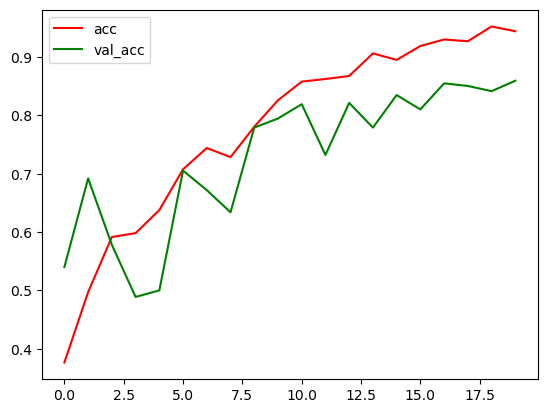

In [21]:
plt.plot(history.history['accuracy'], label='acc', color='red')
plt.plot(history.history['val_accuracy'], label='val_acc', color='green')
plt.legend()

14/14 [==============================] - 1s 42ms/step


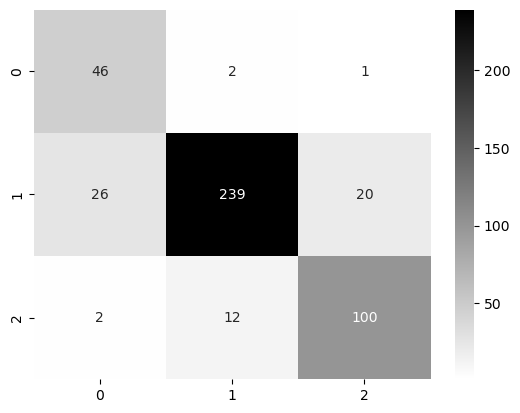

In [22]:
y_pred = model.predict(x_test)
ax = sns.heatmap(confusion_matrix(np.argmax(y_test, axis=1),np.argmax(y_pred, axis=1)), cmap="binary",annot=True,fmt="d")

1/1 [==============================] - 0s 28ms/step


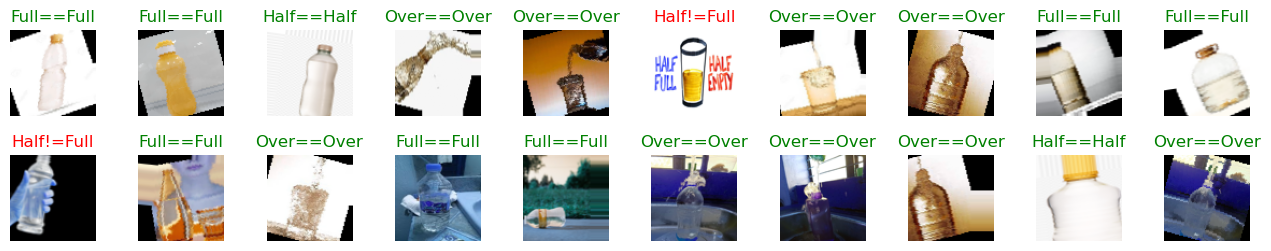

In [23]:

labels = np.array(["Half","Full","Over"]) 
label_dict={i: labels[i] for i in range(len(labels))}
plt.figure(figsize=(16,16))
size=20
for i in range(size):
    index = random.randint(0, x_test.shape[0])
    image = x_test[index]
    plt.subplot(10, 10, i+1)
    plt.imshow(image,  cmap=cm.gray_r)
    plt.subplots_adjust(hspace = 0.2 , wspace = 0.5)
    plt.axis('off')
    y_pred=model.predict(x_test[index:index+1], batch_size=1) 
    k = np.argmax(y_pred)
    l = np.argmax(y_test[index])
    if k == l:
        plt.title(label_dict[k] + "==" + label_dict[l], color='green')
    else:
        plt.title(label_dict[k] + "!=" + label_dict[l], color='#ff0000')

In [24]:
from tensorflow.keras.callbacks import TensorBoard
import datetime

# Set up TensorBoard callback
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


In [25]:
history = model.fit(x_train, y_train, epochs=epochs, verbose=1, validation_data=(x_test, y_test), class_weight=class_weight_dict, callbacks=[tensorboard_callback])


Epoch 1/20
42/42 [==============================] - 7s 177ms/step - loss: 0.1003 - accuracy: 0.9591 - val_loss: 0.4305 - val_accuracy: 0.8772
Epoch 2/20
42/42 [==============================] - 7s 166ms/step - loss: 0.0850 - accuracy: 0.9665 - val_loss: 0.7340 - val_accuracy: 0.8192
Epoch 3/20
42/42 [==============================] - 7s 167ms/step - loss: 0.1605 - accuracy: 0.9345 - val_loss: 0.5947 - val_accuracy: 0.7946
Epoch 4/20
42/42 [==============================] - 7s 171ms/step - loss: 0.1174 - accuracy: 0.9390 - val_loss: 0.3629 - val_accuracy: 0.8817
Epoch 5/20
42/42 [==============================] - 7s 168ms/step - loss: 0.0475 - accuracy: 0.9792 - val_loss: 0.4530 - val_accuracy: 0.8795
Epoch 6/20
42/42 [==============================] - 7s 165ms/step - loss: 0.0342 - accuracy: 0.9844 - val_loss: 0.4718 - val_accuracy: 0.8772
Epoch 7/20
42/42 [==============================] - 7s 177ms/step - loss: 0.1385 - accuracy: 0.9479 - val_loss: 0.3929 - val_accuracy: 0.8839
Epoch 

In [28]:
%load_ext tensorboard
%tensorboard --logdir=./logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6008 (pid 21852), started 0:01:13 ago. (Use '!kill 21852' to kill it.)

In [26]:
# Menyimpan model ke dalam folder 'Save-Model'
model.save("Saved-Model/model.h5")

c:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
